In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
pixel_size = 6  # 6 mm x 6 mm pixels
grid_size = 8   # 8x8 events

## Download data

In [3]:
!mkdir data

# 6x6 dark_walls_6x6_pde_04_ng_50k
# !cd data && wget -O monolithic_csi_dark_walls_6x6_pde_04_ng_50k.tar.gz https://www.dropbox.com/scl/fi/klr0z57pfwqd31uavk3j9/monolithic_csi_dark_walls_6x6_pde_04_ng_50k.tar.gz?rlkey=bjyhttncx3b9h4npl3gc3kdqs&dl=0
# !cd data && tar -xvf monolithic_csi_dark_walls_6x6_pde_04_ng_50k.tar.gz

# 6x6 reflecting_walls_6x6_pde_04_ng_50k
!cd data && wget -O monolithic_csi_reflecting_walls_6x6_pde_04_ng_50k.tar.gz https://www.dropbox.com/scl/fi/oehe0oxe9bmmpuip8ifau/monolithic_csi_reflecting_walls_6x6_pde_04_ng_50k.tar.gz?rlkey=5rhiugsh3ickf5gdrh38l4wr5&dl=0
!cd data && tar -xvf monolithic_csi_reflecting_walls_6x6_pde_04_ng_50k.tar.gz

# 6x6, all reflecting walls
# !cd data && wget -O monolithic_csi_reflecting_all_walls_6x6_pde_04_ng_25k https://www.dropbox.com/scl/fi/u4ibc5brcqh4kqbycmobt/monolithic_csi_reflecting_all_walls_6x6_pde_04_ng_25k.tar.gz?rlkey=tyezscg68nt95lh04glaiyx3s&dl=0
# !cd data && tar -xvf monolithic_csi_reflecting_all_walls_6x6_pde_04_ng_25k

--2023-12-14 19:12:10--  https://www.dropbox.com/scl/fi/oehe0oxe9bmmpuip8ifau/monolithic_csi_reflecting_walls_6x6_pde_04_ng_50k.tar.gz?rlkey=5rhiugsh3ickf5gdrh38l4wr5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucad0c6219948073cd632106a1f9.dl.dropboxusercontent.com/cd/0/inline/CJYOods2LYd0aDVVbkwdY02RPZuhOfKxU33ert04qXvB9-m1mNGw4OVN4_yAidHEunb8dYMOnacpRIueawNeFiXi9zuY6inKkouDkQsLAdN3ZXmzHC-bef3Nj5MC5-iPoDo/file# [following]
--2023-12-14 19:12:11--  https://ucad0c6219948073cd632106a1f9.dl.dropboxusercontent.com/cd/0/inline/CJYOods2LYd0aDVVbkwdY02RPZuhOfKxU33ert04qXvB9-m1mNGw4OVN4_yAidHEunb8dYMOnacpRIueawNeFiXi9zuY6inKkouDkQsLAdN3ZXmzHC-bef3Nj5MC5-iPoDo/file
Resolving ucad0c6219948073cd632106a1f9.dl.dropboxusercontent.com (ucad0c6219948073cd632106a1f9.dl.dropboxusercontent.com)... 162.125.65.15, 2

## Look at a few events

In [4]:
imgs = np.load("data/images_0.npy")
mdata = pd.read_csv("data/metadata_0.csv")

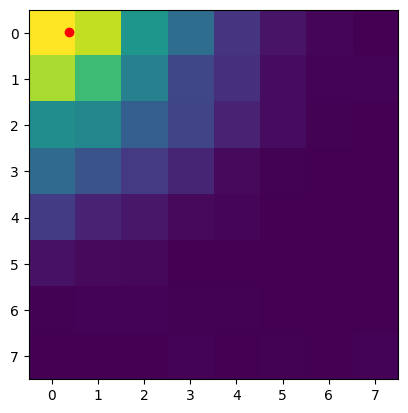

In [7]:
# Pick an event to plot.
ev = 11

# Show the image.
plt.imshow(imgs[ev,:,:])

# Show the event location.
x_evt = (mdata['initial_y'][ev] + pixel_size*grid_size/2)/pixel_size - 0.5
y_evt = (mdata['initial_x'][ev] + pixel_size*grid_size/2)/pixel_size - 0.5
plt.plot([x_evt],[y_evt],'o',color='red')

---

## Position prediction with a neural network

#### The NN class

In [8]:
# Basic CNN for (x,y,z) prediction

chi = 128        # initial number of channels (increase to make net larger)
netdebug = False  # print debugging information for net

class CNN_basic(nn.Module):
    def __init__(self):
        super(CNN_basic, self).__init__()

        self.conv1 = nn.Conv2d(1, chi, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(chi)
        self.conv2 = nn.Conv2d(chi, chi*2, 2, padding=1)
        self.bn2   = nn.BatchNorm2d(chi*2)
        self.conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
        self.bn3   = nn.BatchNorm2d(chi*4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc0 = nn.Linear(chi*4, 3)
        self.drop1 = nn.Dropout(p=0.2)

        # Initialize weights
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

    def forward(self, x):

        if(netdebug): print(x.shape)
        x = self.pool(self.bn1(F.leaky_relu(self.conv1(x))))
        if(netdebug): print(x.shape)
        x = self.pool(self.bn2(F.leaky_relu(self.conv2(x))))
        if(netdebug): print(x.shape)
        x = self.pool(self.bn3(F.leaky_relu(self.conv3(x))))
        if(netdebug): print(x.shape)
        x = x.flatten(start_dim=1)
        if(netdebug): print(x.shape)
        x = self.drop1(x)
        x = self.fc0(x)
        if(netdebug): print(x.shape)

        return x

#### The dataset class

In [9]:
class SiPMDataset(Dataset):

    def __init__(self, data_path, total_files):
        self.data_path = data_path
        self.total_files = total_files
        self.dataset = []

        for i in range(self.total_files):
            images = np.load(f'{self.data_path}/images_{i}.npy')
            metadata = pd.read_csv(f'{self.data_path}/metadata_{i}.csv')

            for img, meta in zip(images, metadata.values):
                self.dataset.append((img, meta[1:]))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, position = self.dataset[idx]
        image = torch.tensor(image, dtype=torch.float).unsqueeze(0) # Add channel dimension
        position = torch.tensor(position, dtype=torch.float)

        return image, position

#### Load the data

In [10]:
# Load the data
data_path = 'data'
total_files = 10  # Number of files to use
batch_size = 1000  # Batch size

dataset = SiPMDataset(data_path, total_files)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
ntot_evts = len(dataset)
print(f"Loaded {len(dataset)} events")

# Split the data into training, validation, and test sets
train_size = int(0.7 * len(dataset))  # training
val_size = int(0.2 * len(dataset))    # validation
test_size = len(dataset) - train_size - val_size  # test
train_indices = range(train_size)
val_indices = range(train_size, train_size + val_size)
test_indices = range(train_size + val_size, len(dataset))

# Define subsets of the dataset
train_dataset = torch.utils.data.Subset(dataset, train_indices)
print(f"{len(train_dataset)} training events ({100*len(train_dataset)/ntot_evts}%)")
val_dataset = torch.utils.data.Subset(dataset, val_indices)
print(f"{len(val_dataset)} validation events ({100*len(val_dataset)/ntot_evts}%)")
test_dataset = torch.utils.data.Subset(dataset, test_indices)
print(f"{len(test_dataset)} test events ({100*len(test_dataset)/ntot_evts}%)")

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Loaded 100000 events
70000 training events (70.0%)
20000 validation events (20.0%)
10000 test events (10.0%)


#### Train the network

In [11]:
# Load the model.
model = CNN_basic()
if torch.cuda.is_available():
    model = model.cuda()

# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 20
train_losses, val_losses = [], []
for epoch in range(epochs):

    train_losses_epoch, val_losses_epoch = [], []

    print(f"\nEPOCH {epoch}")

    # Training step
    for i, (images, positions) in enumerate(train_loader):

        if torch.cuda.is_available():
           images = images.cuda()
           positions = positions.cuda()

        model.train()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, positions)
        loss.backward()
        optimizer.step()
        train_losses_epoch.append(loss.data.item())
        if((i+1) % (len(train_loader)/10) == 0):
            print(f"Train Step {i + 1}/{len(train_loader)}, Loss: {loss.data.item()}")

    # Validation step
    with torch.no_grad():
        model.eval()
        for i, (images, positions) in enumerate(val_loader):

            if torch.cuda.is_available():
              images = images.cuda()
              positions = positions.cuda()

            outputs = model(images)
            loss = criterion(outputs, positions)
            val_losses_epoch.append(loss.data.item())
            if((i+1) % (len(val_loader)/10) == 0):
              print(f"Validation Step {i + 1}/{len(val_loader)}, Loss: {loss.data.item()}")


    train_losses.append(np.mean(train_losses_epoch))
    val_losses.append(np.mean(val_losses_epoch))
    print(f"--- EPOCH {epoch} AVG TRAIN LOSS: {np.mean(train_losses_epoch)}")
    print(f"--- EPOCH {epoch} AVG VAL LOSS: {np.mean(val_losses_epoch)}")


EPOCH 0
Train Step 7/70, Loss: 149.4498291015625
Train Step 14/70, Loss: 57.066551208496094
Train Step 21/70, Loss: 19.324142456054688
Train Step 28/70, Loss: 9.854242324829102
Train Step 35/70, Loss: 8.600154876708984
Train Step 42/70, Loss: 7.346004962921143
Train Step 49/70, Loss: 6.439486980438232
Train Step 56/70, Loss: 5.662196636199951
Train Step 63/70, Loss: 5.156914234161377
Train Step 70/70, Loss: 4.944299221038818
Validation Step 2/20, Loss: 4.167219161987305
Validation Step 4/20, Loss: 4.638087749481201
Validation Step 6/20, Loss: 4.1731367111206055
Validation Step 8/20, Loss: 3.9034035205841064
Validation Step 10/20, Loss: 4.233777046203613
Validation Step 12/20, Loss: 4.104723930358887
Validation Step 14/20, Loss: 4.154876708984375
Validation Step 16/20, Loss: 4.411284923553467
Validation Step 18/20, Loss: 4.242303371429443
Validation Step 20/20, Loss: 4.018915176391602
--- EPOCH 0 AVG TRAIN LOSS: 44.49143018722534
--- EPOCH 0 AVG VAL LOSS: 4.1712890625

EPOCH 1
Train St

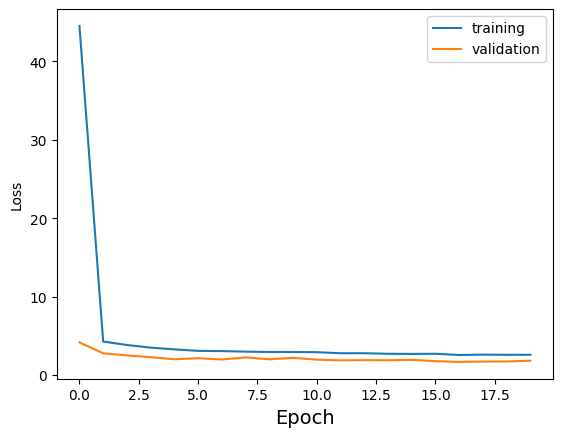

In [12]:
# Plot training and validation loss
xvals_train = np.arange(0,epochs,1)
xvals_val = np.arange(0,epochs,1)
plt.plot(xvals_train,train_losses,label='training')
plt.plot(xvals_val,val_losses,label='validation')
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Loss")
plt.legend()

#### Evaluate the network

In [13]:
def weighted_mean_and_sigma(image):

    # Total intensity of the image
    total_intensity = np.sum(image)

    # Indices for x and y (make (0,0) the center of the 8x8 grid)
    y_indices, x_indices = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    y_indices = np.array(y_indices) - 3.5
    x_indices = np.array(x_indices) - 3.5

    # Weighted means
    weighted_mean_x = np.sum(x_indices * image) / total_intensity
    weighted_mean_y = np.sum(y_indices * image) / total_intensity

    # Weighted standard deviations
    weighted_sigma_x = np.sqrt(np.sum(image * (x_indices - weighted_mean_x)**2) / total_intensity)
    weighted_sigma_y = np.sqrt(np.sum(image * (y_indices - weighted_mean_y)**2) / total_intensity)

    return weighted_mean_x, weighted_mean_y, weighted_sigma_x, weighted_sigma_y

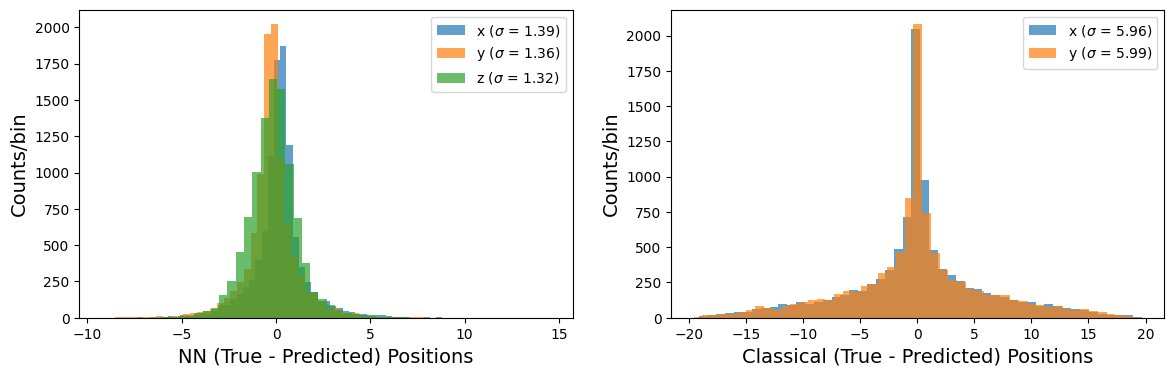

In [14]:
# Evaluate the test set.
true_x, true_y, true_z = [],[],[]
mean_x, mean_y = [],[]
sigma_x, sigma_y = [],[]
predicted_x, predicted_y, predicted_z = [],[],[]
with torch.no_grad():

    model.eval()
    for i, (images, positions) in enumerate(test_loader):

        if torch.cuda.is_available():
            images = images.cuda()

        outputs = model(images).cpu()

        for x in positions[:,0]: true_x.append(x)
        for y in positions[:,1]: true_y.append(y)
        for z in positions[:,2]: true_z.append(z)

        for x in outputs[:,0]: predicted_x.append(x)
        for y in outputs[:,1]: predicted_y.append(y)
        for z in outputs[:,2]: predicted_z.append(z)

        for img in images.cpu().squeeze().numpy():
            mu_x, mu_y, sd_x, sd_y = weighted_mean_and_sigma(img)
            mean_x.append(mu_x); mean_y.append(mu_y)
            sigma_x.append(sd_x); sigma_y.append(sd_y)

# Convert to numpy arrays
true_x = np.array(true_x); true_y = np.array(true_y); true_z = np.array(true_z)
predicted_x = np.array(predicted_x); predicted_y = np.array(predicted_y); predicted_z = np.array(predicted_z)
mean_x = np.array(mean_x); mean_y = np.array(mean_y)
sigma_x = np.array(sigma_x); sigma_y = np.array(sigma_y)

# Compute deltas for the NN.
delta_x_NN = true_x - predicted_x
delta_y_NN = true_y - predicted_y
delta_z_NN = true_z - predicted_z

# Compute deltas for the classical method
delta_x_classical = true_x - pixel_size*mean_x
delta_y_classical = true_y - pixel_size*mean_y

# Histograms of (true - predicted) for x, y, and z
nbins = 50

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
flat_axes = axes.ravel()
ax0, ax1 = flat_axes[0], flat_axes[1]

ax0.hist(delta_x_NN, bins=nbins, label=f"x ($\sigma$ = {np.std(delta_x_NN):.2f})", alpha=0.7)
ax0.hist(delta_y_NN, bins=nbins, label=f"y ($\sigma$ = {np.std(delta_y_NN):.2f})", alpha=0.7)
ax0.hist(delta_z_NN, bins=nbins, label=f"z ($\sigma$ = {np.std(delta_z_NN):.2f})", alpha=0.7)
ax0.set_xlabel("NN (True - Predicted) Positions",fontsize=14)
ax0.set_ylabel("Counts/bin",fontsize=14)
ax0.legend()

ax1.hist(delta_x_classical, bins=nbins, label=f"x ($\sigma$ = {np.std(delta_x_classical):.2f})", alpha=0.7)
ax1.hist(delta_y_classical, bins=nbins, label=f"y ($\sigma$ = {np.std(delta_y_classical):.2f})", alpha=0.7)
ax1.set_xlabel("Classical (True - Predicted) Positions",fontsize=14)
ax1.set_ylabel("Counts/bin",fontsize=14)
ax1.legend()